<a href="https://colab.research.google.com/github/laiss33/Stock-Price-Prediction-using-Multilingual-Sentiment-Analysis/blob/main/%5B3%5DStock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import sklearn.model_selection as ms
import sklearn.preprocessing as p

import tensorflow as tf
import transformers as trfs

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras import regularizers
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Dataset

In [ ]:
mbert = pd.read_excel('/content/drive/MyDrive/shisun_thesis/stock_price_with_mbert.xlsx').set_index('Date').drop(["Unnamed: 0.1","Unnamed: 0"],axis=1).sort_values(by=['company_code','Date'])
mbert.head()

,Close,High,Low,Open,Volume,company_code,company_name,Total_news_past_10days,sentiment_ratio
Date,,,,,,,,,
2019-01-02,4.504456,4.576208,4.480538,4.560263,6022200,1023,IHH Healthcare,7,0.285714
2019-01-03,4.504456,4.560263,4.480538,4.528373,5198100,1023,IHH Healthcare,2,0.000000
2019-01-04,4.488511,4.520401,4.480538,4.488511,3506600,1023,IHH Healthcare,2,0.000000
2019-01-07,4.496483,4.552290,4.496483,4.520400,10358800,1023,IHH Healthcare,5,0.200000
2019-01-08,4.504456,4.552291,4.496483,4.520401,11516600,1023,IHH Healthcare,7,0.285714


In [ ]:
xlm = pd.read_excel('/content/drive/MyDrive/shisun_thesis/stock_price_with_xlm.xlsx').set_index('Date').drop(["Unnamed: 0.1","Unnamed: 0"],axis=1).sort_values(by=['company_code','Date'])
xlm.head()

,Close,High,Low,Open,Volume,company_code,company_name,Total_news_past_10days,sentiment_ratio
Date,,,,,,,,,
2019-01-02,4.504456,4.576208,4.480538,4.560263,6022200,1023,IHH Healthcare,7,-0.142857
2019-01-03,4.504456,4.560263,4.480538,4.528373,5198100,1023,IHH Healthcare,2,0.000000
2019-01-04,4.488511,4.520401,4.480538,4.488511,3506600,1023,IHH Healthcare,2,0.000000
2019-01-07,4.496483,4.552290,4.496483,4.520400,10358800,1023,IHH Healthcare,5,-0.600000
2019-01-08,4.504456,4.552291,4.496483,4.520401,11516600,1023,IHH Healthcare,7,-0.285714


## Correlation Matrix

<Axes: >

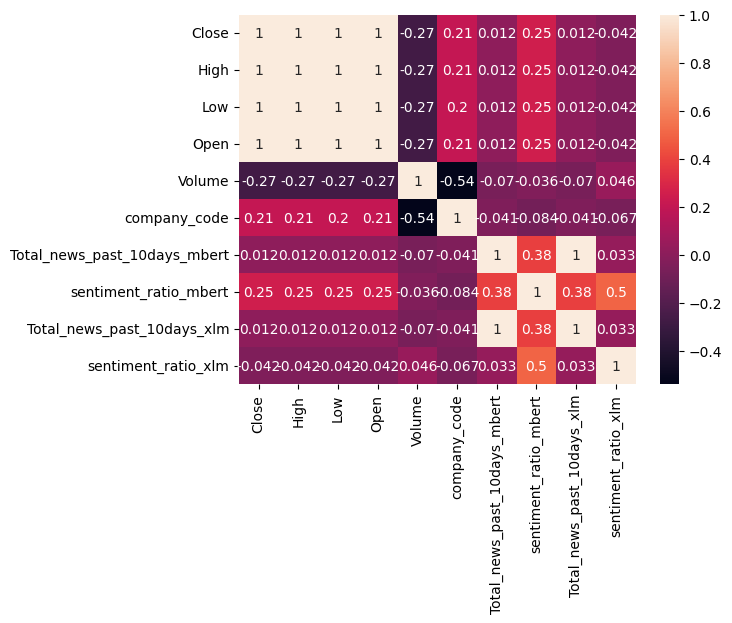

In [ ]:
df = pd.merge(mbert, xlm[['company_name','company_code','Total_news_past_10days','sentiment_ratio']], how='outer', on=['Date', 'company_name','company_code'])
df = df.rename(columns = {'Total_news_past_10days_x':'Total_news_past_10days_mbert','sentiment_ratio_x':'sentiment_ratio_mbert','Total_news_past_10days_y':'Total_news_past_10days_xlm','sentiment_ratio_y':'sentiment_ratio_xlm'})
corr = df.drop(["company_name"],axis=1).corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,annot=True)

## Prediction without news title sentiment

In [ ]:
# First, we get the data
stockList =df.company_name.unique()
df_ = {}
for i in stockList:
    df_[i] = pd.DataFrame(df.loc[df['company_name']==i]["Close"])

In [ ]:
def split(dataframe, border, col):
    return dataframe.loc[:border,col], dataframe.loc[border:,col]

df_new = {}
for i in stockList:
    df_new[i] = {}
    df_new[i]["Train"], df_new[i]["Test"] = split(df_[i], "1st June 2023", ["Close"])

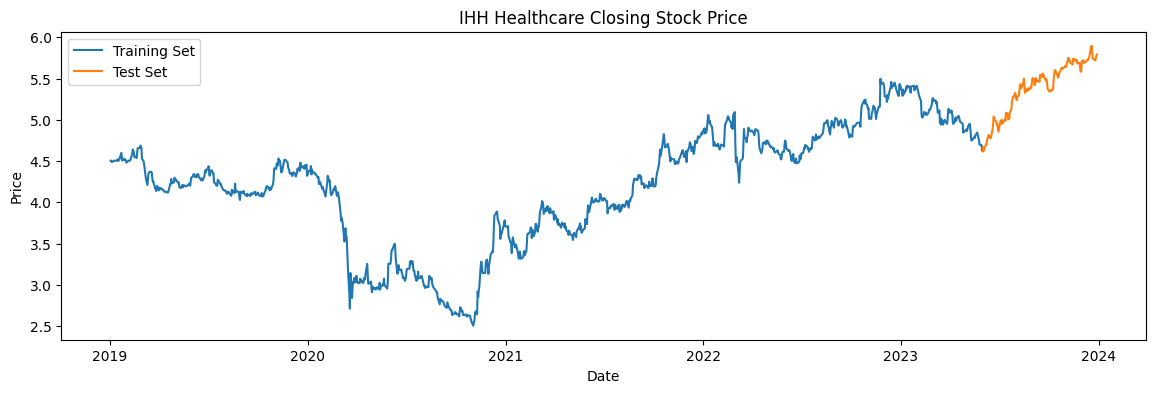

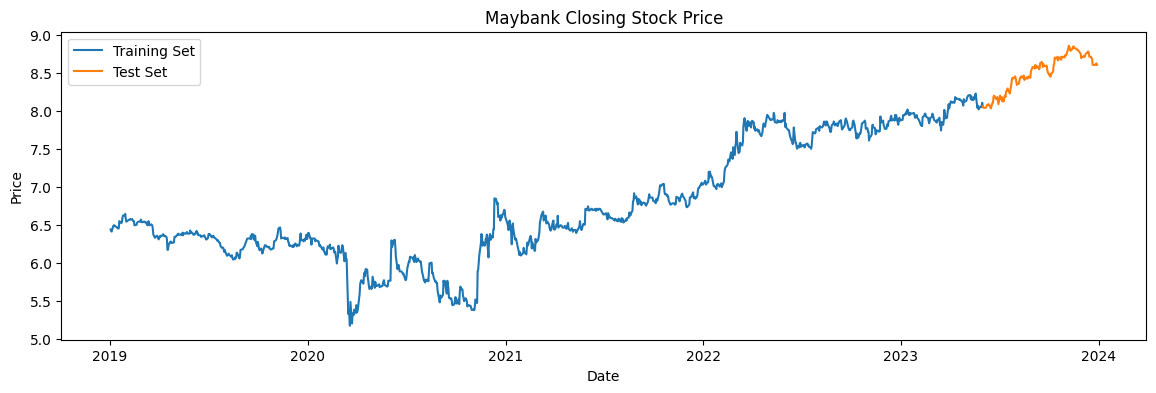

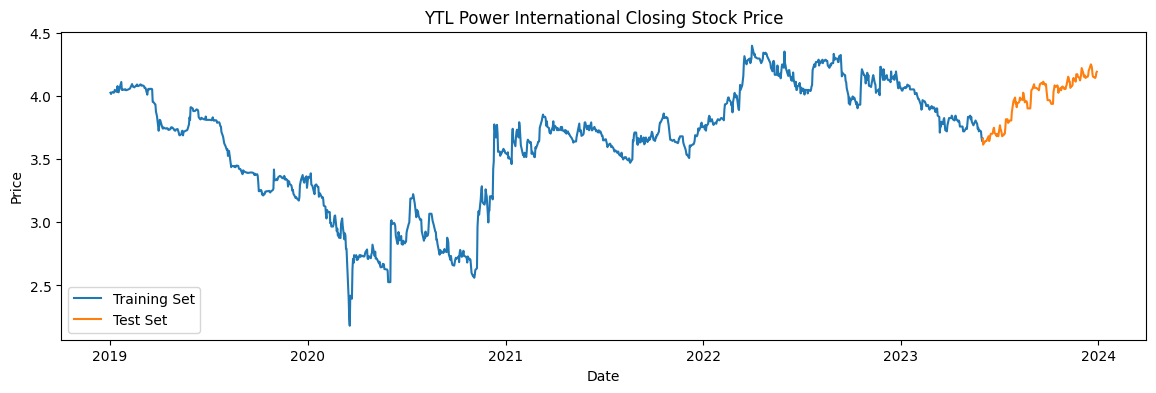

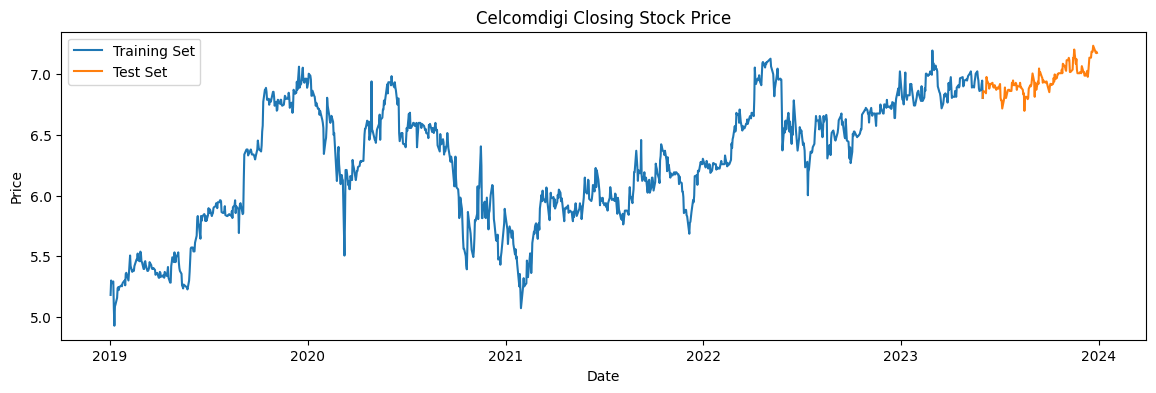

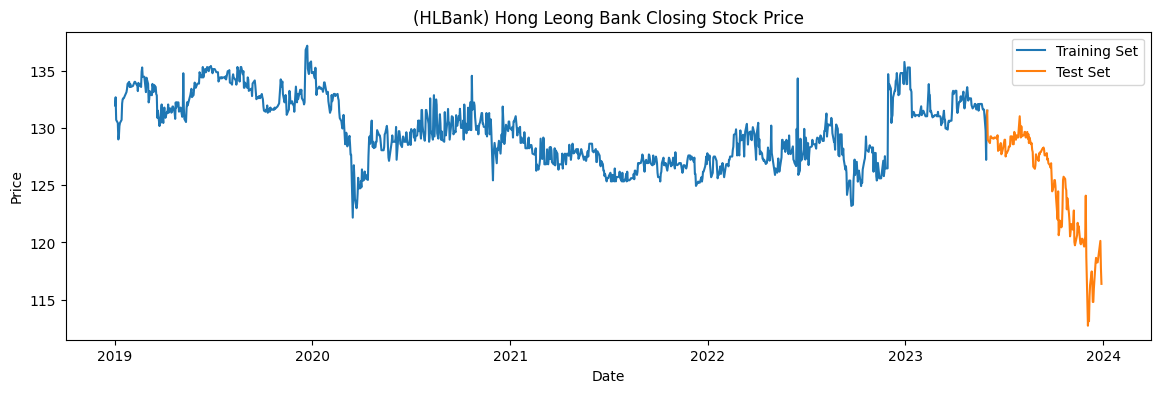

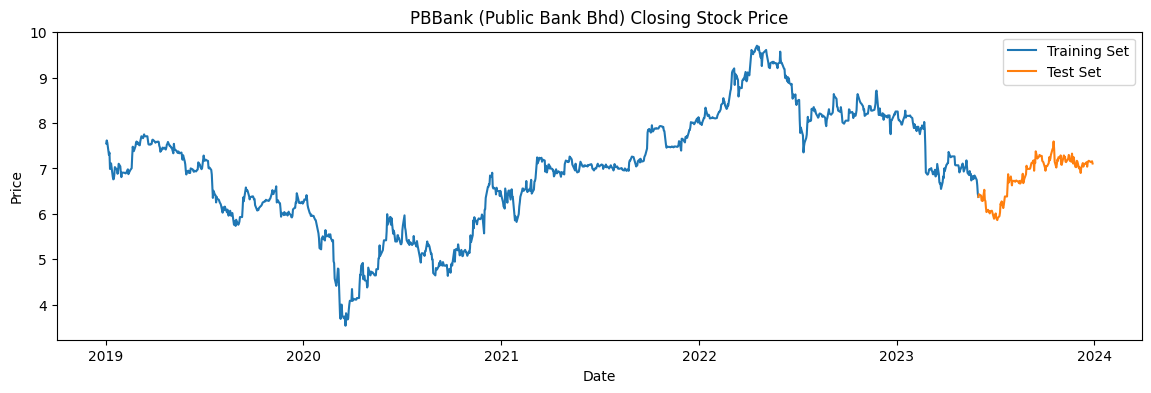

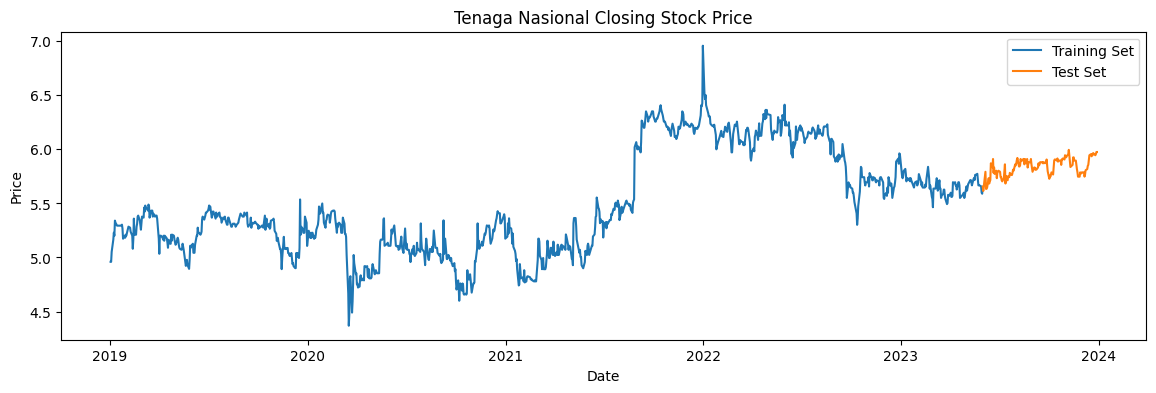

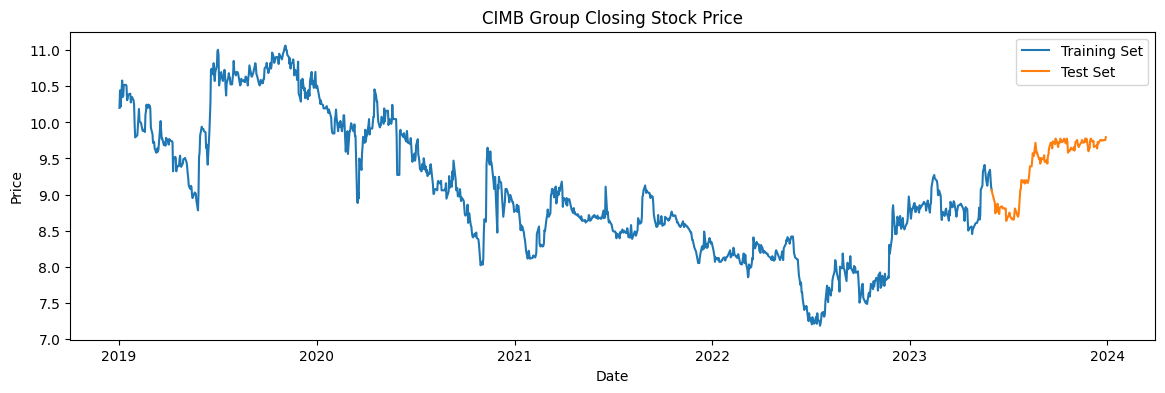

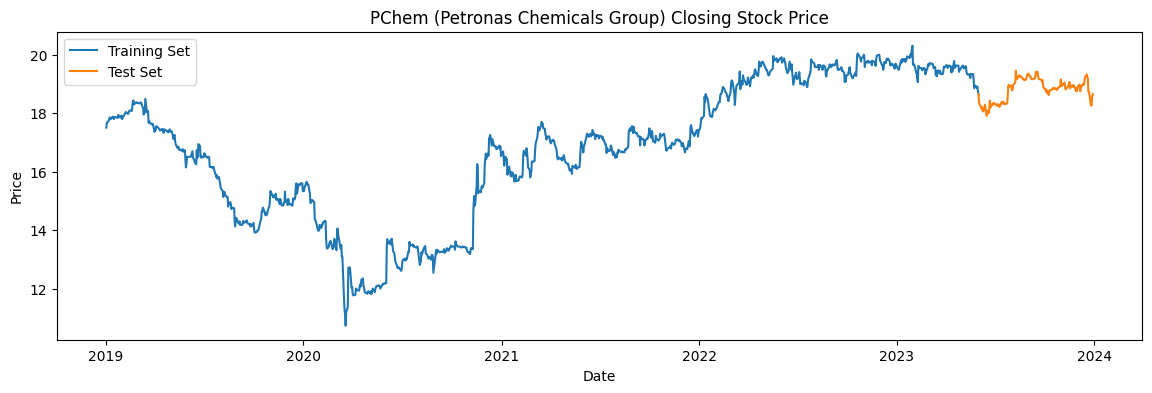

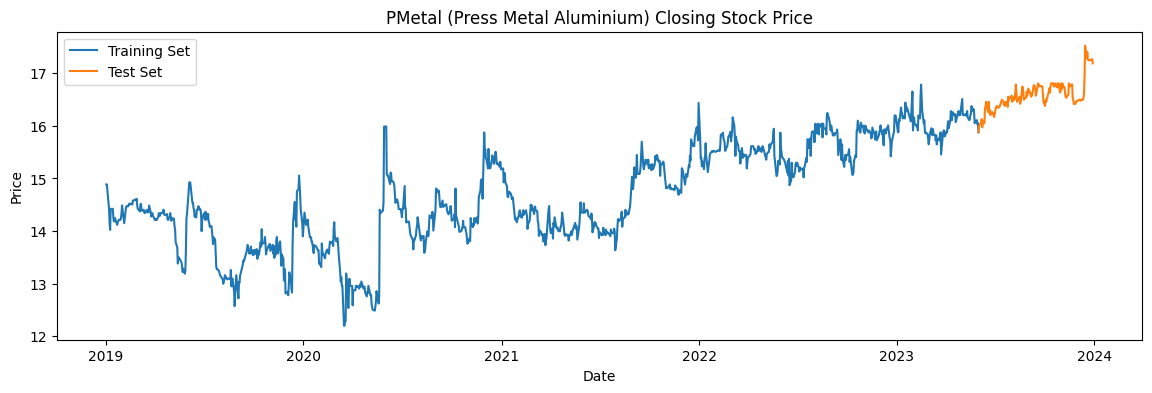

In [ ]:
for i in stockList:
    plt.figure(figsize=(14,4))
    plt.plot(df_new[i]["Train"])
    plt.plot(df_new[i]["Test"])
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.title(i + " Closing Stock Price")

In [ ]:
transform = {}
scaler = {}

for num, i in enumerate(stockList):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_[i])
    a0 = a0.reshape(a0.shape[0],1)
    transform[i] = sc.fit_transform(a0)
    scaler[i] = sc

del a0

In [ ]:
trainset = {}
testset = {}
lookBack = 60

for j in stockList:
    train_len = len(df_new[j]['Train'])
    test_len = len(df_new[j]['Test'])
    trainset[j] = {}
    X_train = []
    y_train = []
    for i in range(train_len- lookBack):
        X_train.append(transform[j][i:i+lookBack,0])
        y_train.append(transform[j][i+lookBack,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset[j]["y"] = y_train


    testset[j] = {}
    X_test = []
    y_test = []
    for i in range(test_len):
        X_test.append(transform[j][-(test_len-i+lookBack):-(test_len-i),0])
        y_test.append(transform[j][-(test_len-i),0])
    y_test,X_test = np.array(y_test),np.array(X_test),
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0],X_train.shape[1],1))
    testset[j]["y"] = y_test


In [ ]:
transform["Maybank"][:]

array([[0.34368219],
       [0.33809567],
       [0.33623414],
       ...,
       [0.93429744],
       [0.93692552],
       [0.93166936]])

In [ ]:
arr_buff = []
for i in stockList:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=stockList)

,X_train,y_train,X_test,y_test
IHH Healthcare,"(1021, 60, 1)","(1021,)","(145, 60, 1)","(145,)"
Maybank,"(1021, 60, 1)","(1021,)","(145, 60, 1)","(145,)"
YTL Power International,"(1021, 60, 1)","(1021,)","(145, 60, 1)","(145,)"
Celcomdigi,"(1021, 60, 1)","(1021,)","(145, 60, 1)","(145,)"
(HLBank) Hong Leong Bank,"(1021, 60, 1)","(1021,)","(145, 60, 1)","(145,)"
PBBank (Public Bank Bhd),"(1021, 60, 1)","(1021,)","(145, 60, 1)","(145,)"
Tenaga Nasional,"(1021, 60, 1)","(1021,)","(145, 60, 1)","(145,)"
CIMB Group,"(1021, 60, 1)","(1021,)","(145, 60, 1)","(145,)"
PChem (Petronas Chemicals Group),"(1021, 60, 1)","(1021,)","(145, 60, 1)","(145,)"
PMetal (Press Metal Aluminium),"(1021, 60, 1)","(1021,)","(145, 60, 1)","(145,)"


In [ ]:
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(lookBack, 1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
# Fitting to the training set
for i in stockList:
    print("Fitting to", i)
    regressor.fit(trainset[i]["X"], trainset[i]["y"], epochs=10, batch_size=200)

Fitting to IHH Healthcare
Epoch 1/10
6/6 [==============================] - 11s 559ms/step - loss: 0.1097
Epoch 2/10
6/6 [==============================] - 2s 332ms/step - loss: 0.0359
Epoch 3/10
6/6 [==============================] - 2s 303ms/step - loss: 0.0191
Epoch 4/10
6/6 [==============================] - 2s 304ms/step - loss: 0.0422
Epoch 5/10
6/6 [==============================] - 2s 293ms/step - loss: 0.0186
Epoch 6/10
6/6 [==============================] - 2s 303ms/step - loss: 0.0216
Epoch 7/10
6/6 [==============================] - 2s 416ms/step - loss: 0.0224
Epoch 8/10
6/6 [==============================] - 3s 557ms/step - loss: 0.0215
Epoch 9/10
6/6 [==============================] - 3s 421ms/step - loss: 0.0246
Epoch 10/10
6/6 [==============================] - 3s 441ms/step - loss: 0.0125
Fitting to Maybank
Epoch 1/10
6/6 [==============================] - 2s 302ms/step - loss: 0.0188
Epoch 2/10
6/6 [==============================] - 3s 538ms/step - loss: 0.0147
Epoch

## Predcition with MBERT news title sentiment

In [ ]:

mbert_df_ = {}
for i in stockList:
    mbert_df_[i] = pd.DataFrame(df.loc[df['company_name']==i][["Close","sentiment_ratio_mbert"]])

In [ ]:
mbert_transform= {}
mbert_scaler = {}

for num, i in enumerate(stockList):
    mbert_sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(mbert_df_[i])
    a0 = a0.reshape(a0.shape[0],2)
    mbert_transform[i] = mbert_sc.fit_transform(a0)
    mbert_scaler[i] = mbert_sc

del a0

In [ ]:
mbert_trainset = {}
mbert_testset = {}
lookBack = 60
for j in stockList:
    train_len = len(df_new[j]['Train'])
    test_len = len(df_new[j]['Test'])
    mbert_trainset[j] = {}
    mbert_X_train = []
    mbert_y_train = []
    for i in range(train_len- lookBack):
        mbert_X_train.append(mbert_transform[j][i:i+lookBack,:])
        mbert_y_train.append(mbert_transform[j][i+lookBack,0])
    mbert_X_train, mbert_y_train = np.array(mbert_X_train), np.array(mbert_y_train)
    mbert_trainset[j]["X"] = np.reshape(mbert_X_train, (mbert_X_train.shape[0],mbert_X_train.shape[1],2))
    mbert_trainset[j]["y"] =mbert_y_train


    mbert_testset[j] = {}
    mbert_X_test = []
    mbert_y_test = []
    for i in range(test_len):
        mbert_X_test.append(mbert_transform[j][-(test_len-i+lookBack):-(test_len-i),:])
        mbert_y_test.append(mbert_transform[j][-(test_len-i),0])
    mbert_X_test, mbert_y_test = np.array(mbert_X_test), np.array(mbert_y_test)
    mbert_testset[j]["X"] = np.reshape(mbert_X_test, (mbert_X_test.shape[0],mbert_X_train.shape[1],2))
    mbert_testset[j]["y"] = mbert_y_test




In [ ]:
arr_buff = []
for i in stockList:
    buff = {}
    buff["mbert_X_train"] = mbert_trainset[i]["X"].shape
    buff["mbert_y_train"] = mbert_trainset[i]["y"].shape
    buff["mbert_X_test"] = mbert_testset[i]["X"].shape
    buff["mbert_y_test"] = mbert_testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=stockList)

,mbert_X_train,mbert_y_train,mbert_X_test,mbert_y_test
IHH Healthcare,"(1021, 60, 2)","(1021,)","(145, 60, 2)","(145,)"
Maybank,"(1021, 60, 2)","(1021,)","(145, 60, 2)","(145,)"
YTL Power International,"(1021, 60, 2)","(1021,)","(145, 60, 2)","(145,)"
Celcomdigi,"(1021, 60, 2)","(1021,)","(145, 60, 2)","(145,)"
(HLBank) Hong Leong Bank,"(1021, 60, 2)","(1021,)","(145, 60, 2)","(145,)"
PBBank (Public Bank Bhd),"(1021, 60, 2)","(1021,)","(145, 60, 2)","(145,)"
Tenaga Nasional,"(1021, 60, 2)","(1021,)","(145, 60, 2)","(145,)"
CIMB Group,"(1021, 60, 2)","(1021,)","(145, 60, 2)","(145,)"
PChem (Petronas Chemicals Group),"(1021, 60, 2)","(1021,)","(145, 60, 2)","(145,)"
PMetal (Press Metal Aluminium),"(1021, 60, 2)","(1021,)","(145, 60, 2)","(145,)"


In [ ]:
# The LSTM architecture
mbert_regressor = Sequential()
# First LSTM layer with Dropout regularisation
mbert_regressor.add(LSTM(units=50, return_sequences=True, input_shape=(lookBack, 2)))
mbert_regressor.add(Dropout(0.2))
# Second LSTM layer
mbert_regressor.add(LSTM(units=50, return_sequences=True))
mbert_regressor.add(Dropout(0.2))
# Third LSTM layer
mbert_regressor.add(LSTM(units=50, return_sequences=True))
mbert_regressor.add(Dropout(0.5))
# Fourth LSTM layer
mbert_regressor.add(LSTM(units=50))
mbert_regressor.add(Dropout(0.5))
# The output layer
mbert_regressor.add(Dense(units=1))

# Compiling the RNN
mbert_regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
for i in stockList:
    print("Fitting to", i)
    mbert_regressor.fit(mbert_trainset[i]["X"], mbert_trainset[i]["y"], epochs=10, batch_size=200)

Fitting to IHH Healthcare
Epoch 1/10
6/6 [==============================] - 11s 553ms/step - loss: 0.1197
Epoch 2/10
6/6 [==============================] - 2s 307ms/step - loss: 0.0366
Epoch 3/10
6/6 [==============================] - 2s 316ms/step - loss: 0.0241
Epoch 4/10
6/6 [==============================] - 2s 312ms/step - loss: 0.0226
Epoch 5/10
6/6 [==============================] - 2s 313ms/step - loss: 0.0226
Epoch 6/10
6/6 [==============================] - 2s 310ms/step - loss: 0.0152
Epoch 7/10
6/6 [==============================] - 3s 574ms/step - loss: 0.0150
Epoch 8/10
6/6 [==============================] - 3s 400ms/step - loss: 0.0245
Epoch 9/10
6/6 [==============================] - 2s 314ms/step - loss: 0.0208
Epoch 10/10
6/6 [==============================] - 2s 316ms/step - loss: 0.0173
Fitting to Maybank
Epoch 1/10
6/6 [==============================] - 3s 447ms/step - loss: 0.0114
Epoch 2/10
6/6 [==============================] - 3s 533ms/step - loss: 0.0148
Epoch

## Predcition with xlm-RoBERTa news title sentiment





In [ ]:

xlm_df_ = {}
for i in stockList:
    xlm_df_[i] = pd.DataFrame(df.loc[df['company_name']==i][["Close","sentiment_ratio_xlm"]])

In [ ]:
xlm_transform= {}
xlm_scaler = {}

for num, i in enumerate(stockList):
    xlm_sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(xlm_df_[i])
    a0 = a0.reshape(a0.shape[0],2)
    xlm_transform[i] = xlm_sc.fit_transform(a0)
    xlm_scaler[i] =xlm_sc

del a0

In [ ]:
xlm_trainset = {}
xlm_testset = {}
lookBack = 60
for j in stockList:
    train_len = len(df_new[j]['Train'])
    test_len = len(df_new[j]['Test'])
    xlm_trainset[j] = {}
    xlm_X_train = []
    xlm_y_train = []
    for i in range(train_len- lookBack):
        xlm_X_train.append(xlm_transform[j][i:i+lookBack,:])
        xlm_y_train.append(xlm_transform[j][i+lookBack,0])
    xlm_X_train, xlm_y_train = np.array(xlm_X_train), np.array(xlm_y_train)
    xlm_trainset[j]["X"] = np.reshape(xlm_X_train, (xlm_X_train.shape[0],xlm_X_train.shape[1],2))
    xlm_trainset[j]["y"] =xlm_y_train


    xlm_testset[j] = {}
    xlm_X_test = []
    xlm_y_test = []
    for i in range(test_len):
        xlm_X_test.append(xlm_transform[j][-(test_len-i+lookBack):-(test_len-i),:])
        xlm_y_test.append(xlm_transform[j][-(test_len-i),0])
    xlm_X_test, xlm_y_test = np.array(xlm_X_test), np.array(xlm_y_test)
    xlm_testset[j]["X"] = np.reshape(xlm_X_test, (xlm_X_test.shape[0],xlm_X_train.shape[1],2))
    xlm_testset[j]["y"] = xlm_y_test




In [ ]:
arr_buff = []
for i in stockList:
    buff = {}
    buff["xlm_X_train"] = xlm_trainset[i]["X"].shape
    buff["xlm_y_train"] = xlm_trainset[i]["y"].shape
    buff["xlm_X_test"] = xlm_testset[i]["X"].shape
    buff["xlm_y_test"] = xlm_testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=stockList)

,xlm_X_train,xlm_y_train,xlm_X_test,xlm_y_test
IHH Healthcare,"(1021, 60, 2)","(1021,)","(145, 60, 2)","(145,)"
Maybank,"(1021, 60, 2)","(1021,)","(145, 60, 2)","(145,)"
YTL Power International,"(1021, 60, 2)","(1021,)","(145, 60, 2)","(145,)"
Celcomdigi,"(1021, 60, 2)","(1021,)","(145, 60, 2)","(145,)"
(HLBank) Hong Leong Bank,"(1021, 60, 2)","(1021,)","(145, 60, 2)","(145,)"
PBBank (Public Bank Bhd),"(1021, 60, 2)","(1021,)","(145, 60, 2)","(145,)"
Tenaga Nasional,"(1021, 60, 2)","(1021,)","(145, 60, 2)","(145,)"
CIMB Group,"(1021, 60, 2)","(1021,)","(145, 60, 2)","(145,)"
PChem (Petronas Chemicals Group),"(1021, 60, 2)","(1021,)","(145, 60, 2)","(145,)"
PMetal (Press Metal Aluminium),"(1021, 60, 2)","(1021,)","(145, 60, 2)","(145,)"


In [ ]:
# The LSTM architecture
xlm_regressor = Sequential()
# First LSTM layer with Dropout regularisation
xlm_regressor.add(LSTM(units=50, return_sequences=True, input_shape=(lookBack, 2)))
xlm_regressor.add(Dropout(0.2))
# Second LSTM layer
xlm_regressor.add(LSTM(units=50, return_sequences=True))
xlm_regressor.add(Dropout(0.2))
# Third LSTM layer
xlm_regressor.add(LSTM(units=50, return_sequences=True))
xlm_regressor.add(Dropout(0.5))
# Fourth LSTM layer
xlm_regressor.add(LSTM(units=50))
xlm_regressor.add(Dropout(0.5))
# The output layer
xlm_regressor.add(Dense(units=1))

# Compiling the RNN
xlm_regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
for i in stockList:
    print("Fitting to", i)
    xlm_regressor.fit(xlm_trainset[i]["X"], xlm_trainset[i]["y"], epochs=10, batch_size=200)

Fitting to IHH Healthcare
Epoch 1/10
6/6 [==============================] - 10s 499ms/step - loss: 0.1297
Epoch 2/10
6/6 [==============================] - 3s 482ms/step - loss: 0.0265
Epoch 3/10
6/6 [==============================] - 2s 301ms/step - loss: 0.0409
Epoch 4/10
6/6 [==============================] - 2s 304ms/step - loss: 0.0212
Epoch 5/10
6/6 [==============================] - 2s 303ms/step - loss: 0.0189
Epoch 6/10
6/6 [==============================] - 2s 301ms/step - loss: 0.0277
Epoch 7/10
6/6 [==============================] - 2s 305ms/step - loss: 0.0250
Epoch 8/10
6/6 [==============================] - 3s 544ms/step - loss: 0.0221
Epoch 9/10
6/6 [==============================] - 3s 406ms/step - loss: 0.0163
Epoch 10/10
6/6 [==============================] - 2s 306ms/step - loss: 0.0215
Fitting to Maybank
Epoch 1/10
6/6 [==============================] - 2s 311ms/step - loss: 0.0170
Epoch 2/10
6/6 [==============================] - 2s 306ms/step - loss: 0.0145
Epoch

## Evaluation

In [ ]:
pred_result = {}
for i in stockList:
    trainPredict = regressor.predict(trainset[i]["X"])
    testPredict = regressor.predict(testset[i]["X"])

    trainPredictInv = sc.inverse_transform(trainPredict)
    trainYInv = sc.inverse_transform(np.reshape(trainset[i]["y"], (trainset[i]["y"].shape[0], 1)))
    testPredictInv = sc.inverse_transform(testPredict)
    testYInv = sc.inverse_transform(np.reshape(testset[i]["y"], (testset[i]["y"].shape[0], 1)))

    pred_result[i] = {}

    pred_result[i]["Date_train"] = np.reshape(df_[i][60:1081].index.values, (df_[i][60:1081].index.values.shape[0], 1))
    pred_result[i]["Date_test"] = np.reshape(df_[i][1080:].index.values, (df_[i][1080:].index.values.shape[0], 1))
    pred_result[i]["True_train"] = trainYInv
    pred_result[i]["True_test"] = testYInv
    pred_result[i]["Pred"] = testPredictInv

5/5 [==============================] - 0s 30ms/step


In [ ]:
for i in stockList:
  mbert_trainPredict = mbert_regressor.predict(mbert_trainset[i]["X"])
  mbert_testPredict = mbert_regressor.predict(mbert_testset[i]["X"])

  mbert_trainPredictInv = sc.inverse_transform(mbert_trainPredict)
  mbert_trainYInv = sc.inverse_transform(np.reshape(mbert_trainset[i]["y"], (mbert_trainset[i]["y"].shape[0], 1)))
  mbert_testPredictInv = sc.inverse_transform(mbert_testPredict)
  mbert_testYInv = sc.inverse_transform(np.reshape(mbert_testset[i]["y"], (mbert_testset[i]["y"].shape[0], 1)))


  pred_result[i]["mbert_Pred"] = mbert_testPredictInv

5/5 [==============================] - 0s 32ms/step


In [ ]:
for i in stockList:
  xlm_trainPredict = xlm_regressor.predict(xlm_trainset[i]["X"])
  xlm_testPredict = xlm_regressor.predict(xlm_testset[i]["X"])

  xlm_trainPredictInv = sc.inverse_transform(xlm_trainPredict)
  xlm_trainYInv = sc.inverse_transform(np.reshape(xlm_trainset[i]["y"], (xlm_trainset[i]["y"].shape[0], 1)))
  xlm_testPredictInv = sc.inverse_transform(xlm_testPredict)
  xlm_testYInv = sc.inverse_transform(np.reshape(xlm_testset[i]["y"], (xlm_testset[i]["y"].shape[0], 1)))


  pred_result[i]["xlm_Pred"] = xlm_testPredictInv

5/5 [==============================] - 0s 30ms/step


In [ ]:
eval_result = []
for i in stockList:
#     trainScore = np.sqrt(mean_squared_error(trainYInv[:, 0], trainPredictInv[:, 0]))
    rmse = np.sqrt(mean_squared_error(pred_result[i]["True_test"][:, 0], pred_result[i]["Pred"][:, 0]))
    # trainAccuracy = 100 - (rmse / np.mean(pred_result[i]["True"][:, 0]) * 100)
    mape = np.mean(np.abs((pred_result[i]["True_test"][:, 0] - pred_result[i]["Pred"][:, 0])/ pred_result[i]["True_test"][:, 0])) * 100
    eval_result.append({"dataset":"stock price only","company":i,"RMSE":rmse,"MAPE":mape
                        # ,"acc":trainAccuracy
                        })

    mbert_rmse = np.sqrt(mean_squared_error(pred_result[i]["True_test"][:, 0], pred_result[i]["mbert_Pred"][:, 0]))
    # mbert_trainAccuracy = 100 - (mbert_rmse / np.mean(pred_result[i]["True"][:, 0]) * 100)
    mbert_mape = np.mean(np.abs((pred_result[i]["True_test"][:, 0] - pred_result[i]["mbert_Pred"][:, 0])/ pred_result[i]["True_test"][:, 0])) * 100
    eval_result.append({"dataset":"stock price + mBERT","company":i,"RMSE":mbert_rmse,"MAPE":mbert_mape
                        # ,"acc":mbert_trainAccuracy
                        })

    xlm_rmse = np.sqrt(mean_squared_error(pred_result[i]["True_test"][:, 0], pred_result[i]["xlm_Pred"][:, 0]))
    # mbert_trainAccuracy = 100 - (mbert_rmse / np.mean(pred_result[i]["True"][:, 0]) * 100)
    xlm_mape = np.mean(np.abs((pred_result[i]["True_test"][:, 0] - pred_result[i]["xlm_Pred"][:, 0])/ pred_result[i]["True_test"][:, 0])) * 100
    eval_result.append({"dataset":"stock price + xlm","company":i,"RMSE":xlm_rmse,"MAPE":xlm_mape
                        # ,"acc":mbert_trainAccuracy
                        })
eval_result=pd.DataFrame(eval_result)

In [ ]:
table = pd.pivot_table(eval_result, values=['RMSE','MAPE'],columns=['dataset'], aggfunc="mean")
table

dataset,stock price + mBERT,stock price + xlm,stock price only
MAPE,3.581202,1.238224,3.027243
RMSE,0.615257,0.248313,0.526563


In [ ]:
table = pd.pivot_table(eval_result, values=['RMSE','MAPE'], index=['company'],columns=['dataset'], aggfunc="sum")
table

MAPE                    \
dataset                          stock price + mBERT stock price + xlm   
company                                                                  
(HLBank) Hong Leong Bank                    2.641871          2.494323   
CIMB Group                                  2.579698          1.144413   
Celcomdigi                                  4.484022          1.174426   
IHH Healthcare                              4.554869          1.274786   
Maybank                                     4.631721          1.273684   
PBBank (Public Bank Bhd)                    1.945456          1.006504   
PChem (Petronas Chemicals Group)            4.102823          0.956475   
PMetal (Press Metal Aluminium)              4.264033          1.059054   
Tenaga Nasional                             2.373965          0.787006   
YTL Power International                     4.233562          1.211573   

                                                                 RMSE  \
dataset                          stock price only stock price + mBERT   
company                                                                 
(HLBank) Hong Leong Bank                 2.417253            0.470783   
CIMB Group                               2.055331            0.440827   
Celcomdigi                               3.862964            0.778668   
IHH Healthcare                           3.899166            0.780908   
Maybank                                  4.079375            0.799794   
PBBank (Public Bank Bhd)                 1.623074            0.335327   
PChem (Petronas Chemicals Group)         3.463783            0.701803   
PMetal (Press Metal Aluminium)           3.605135            0.737119   
Tenaga Nasional                          1.752007            0.387478   
YTL Power International                  3.514339            0.719867   

                                                                     
dataset                          stock price + xlm stock price only  
company                                                              
(HLBank) Hong Leong Bank                  0.488218         0.440223  
CIMB Group                                0.239310         0.355846  
Celcomdigi                                0.246484         0.674694  
IHH Healthcare                            0.241239         0.674199  
Maybank                                   0.249743         0.705332  
PBBank (Public Bank Bhd)                  0.195466         0.281785  
PChem (Petronas Chemicals Group)          0.187371         0.596618  
PMetal (Press Metal Aluminium)            0.257142         0.632276  
Tenaga Nasional                           0.153383         0.299145  
YTL Power International                   0.224772         0.605508

<Axes: xlabel='company'>

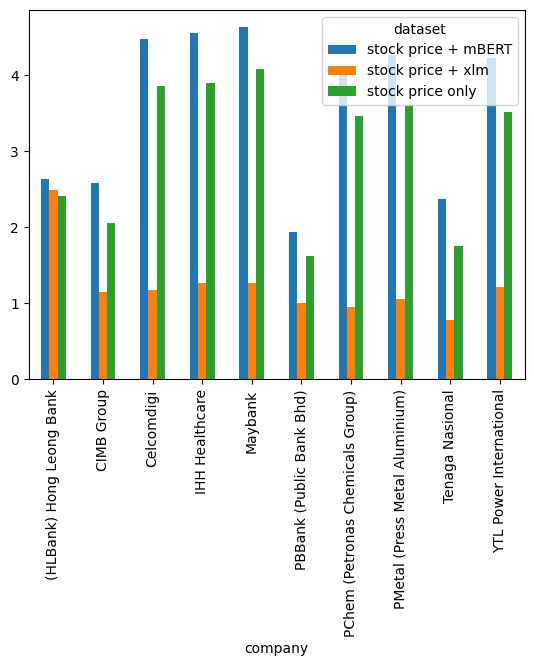

In [ ]:
table.MAPE.plot( kind="bar")

<Axes: xlabel='company'>

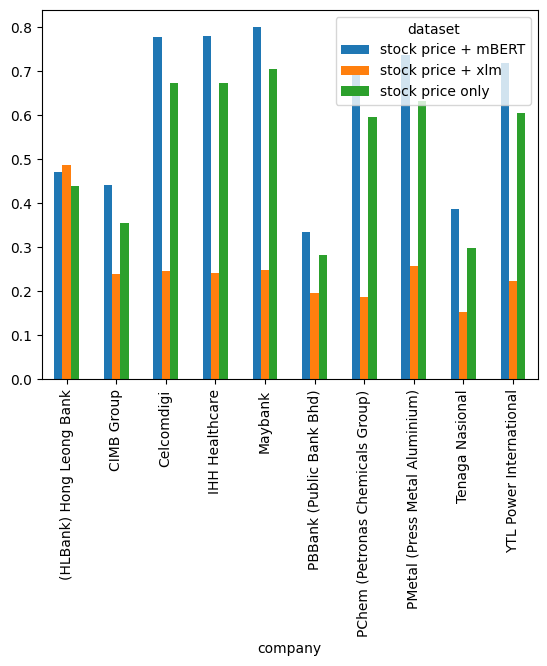

In [ ]:
table.RMSE.plot( kind="bar")

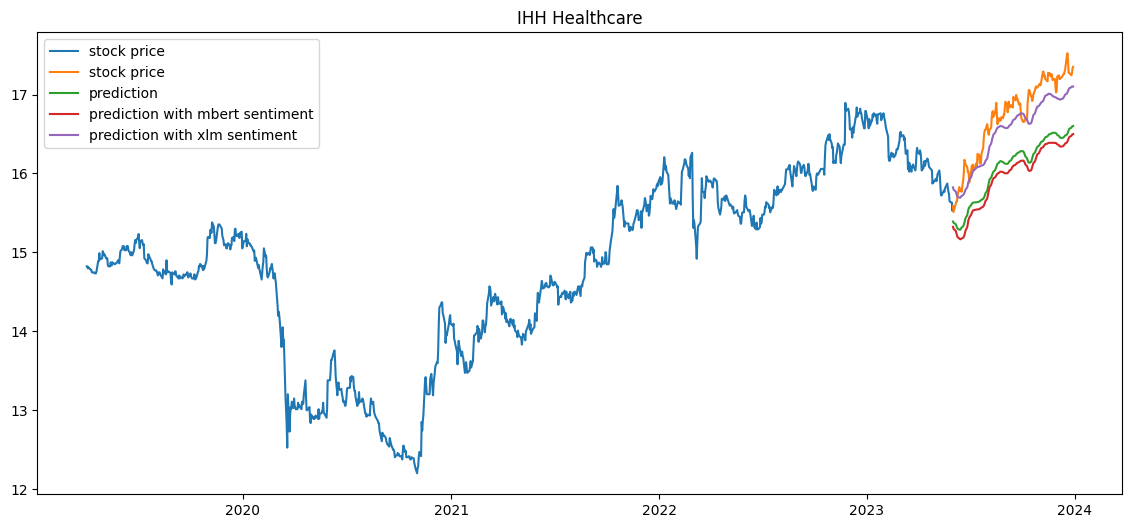

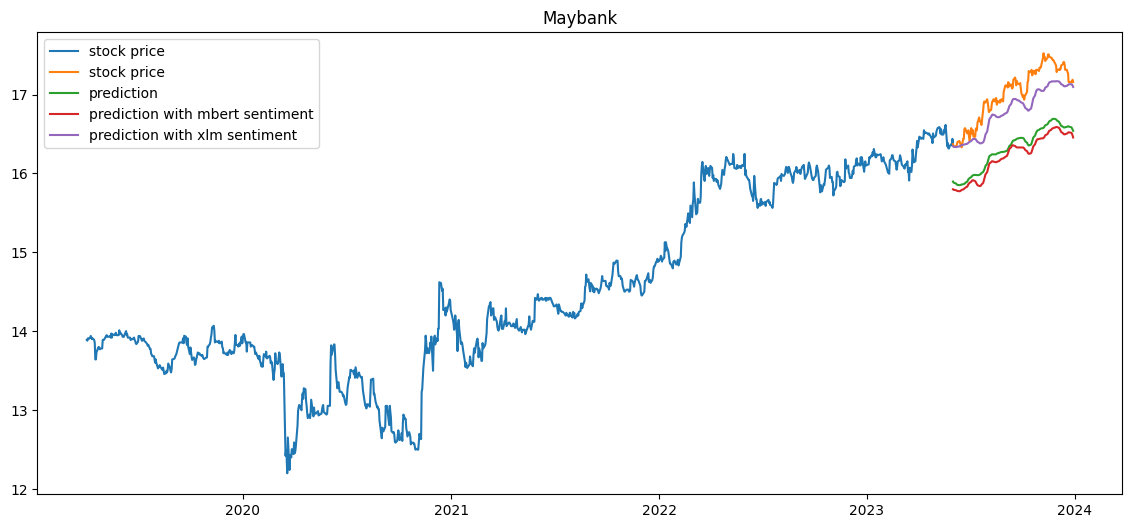

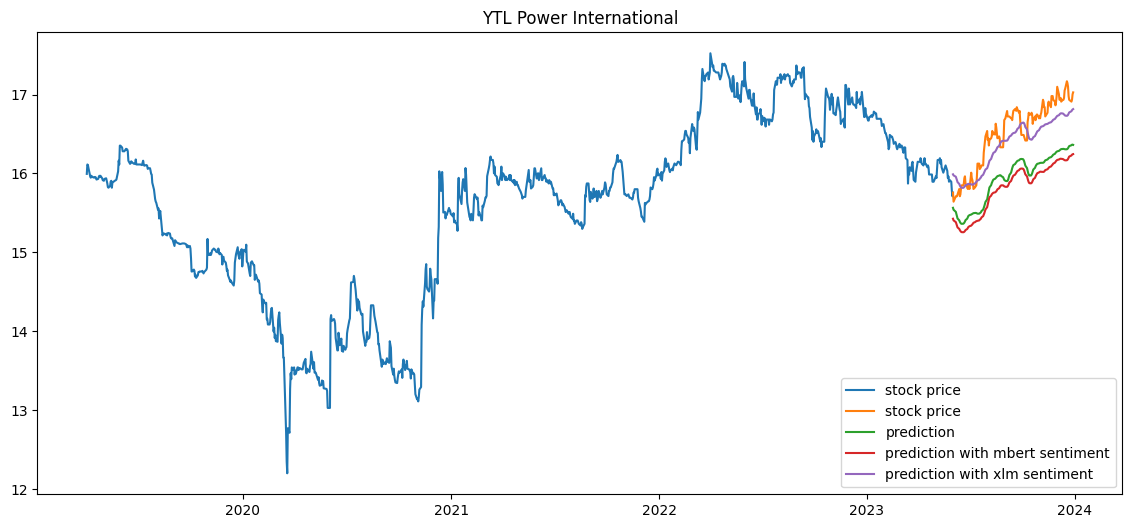

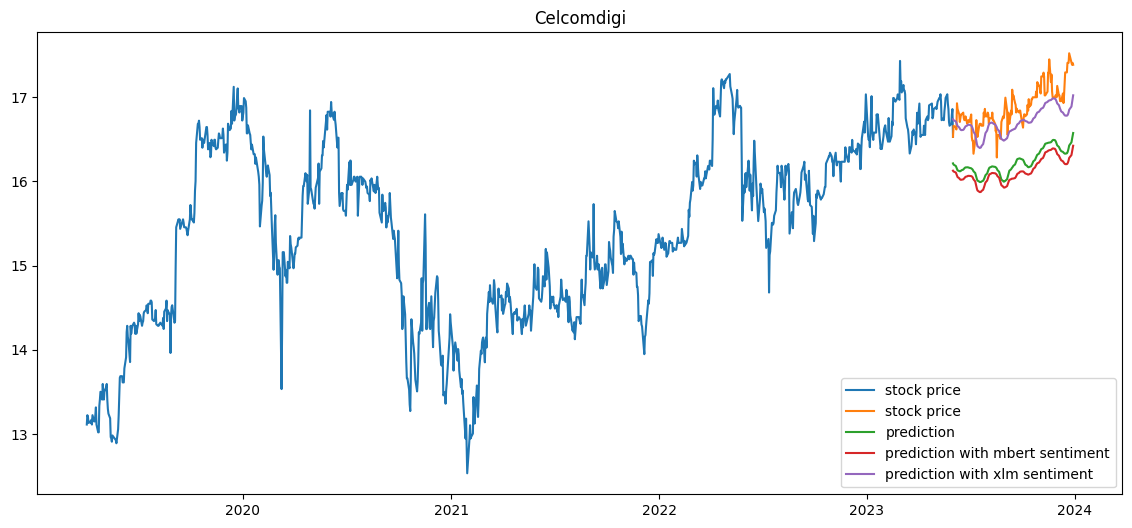

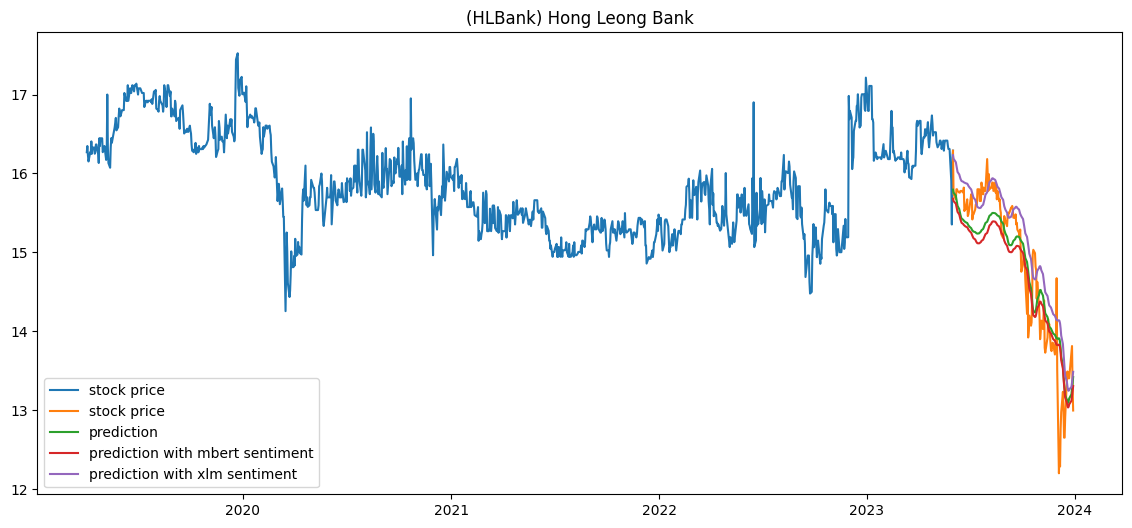

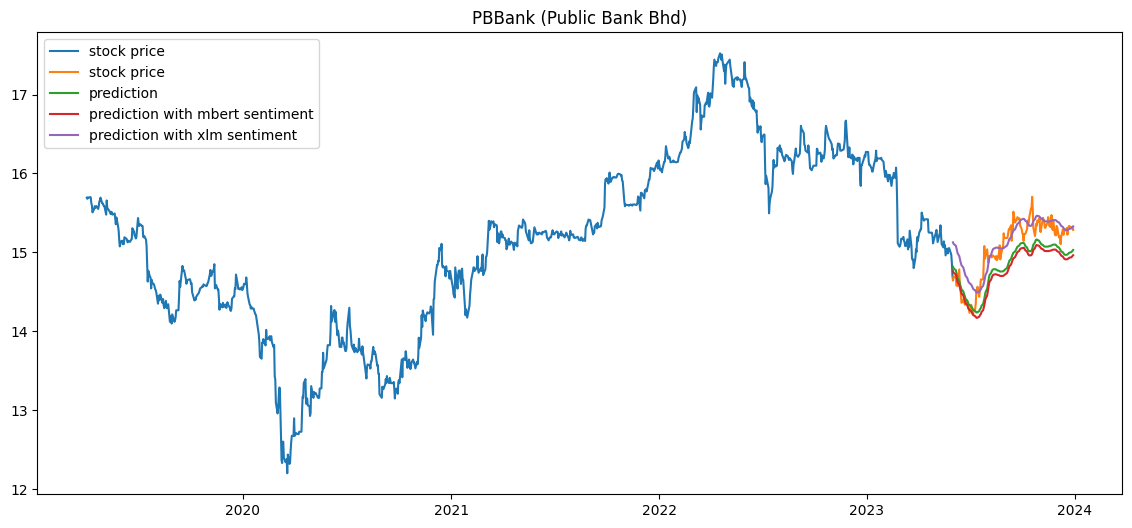

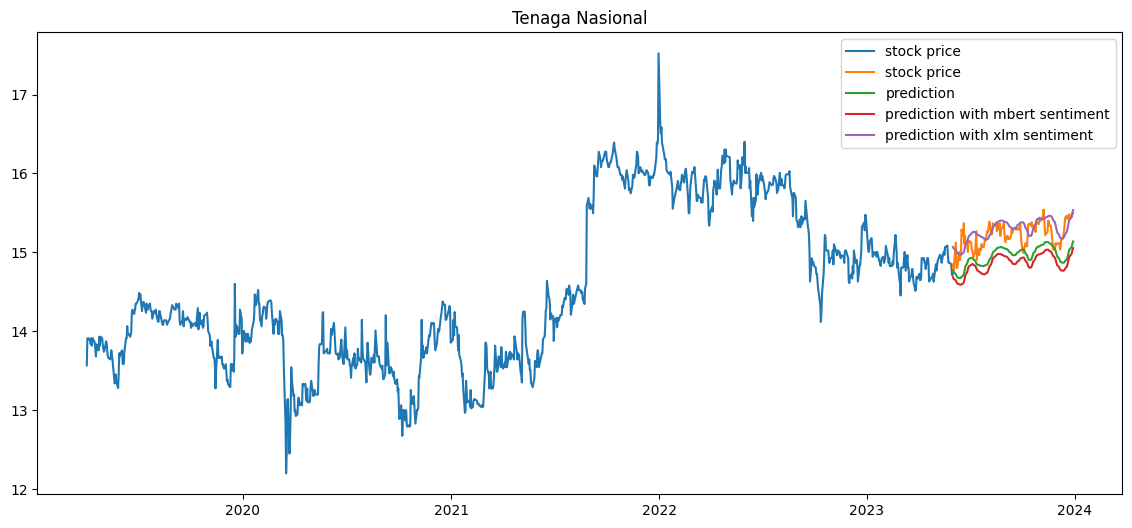

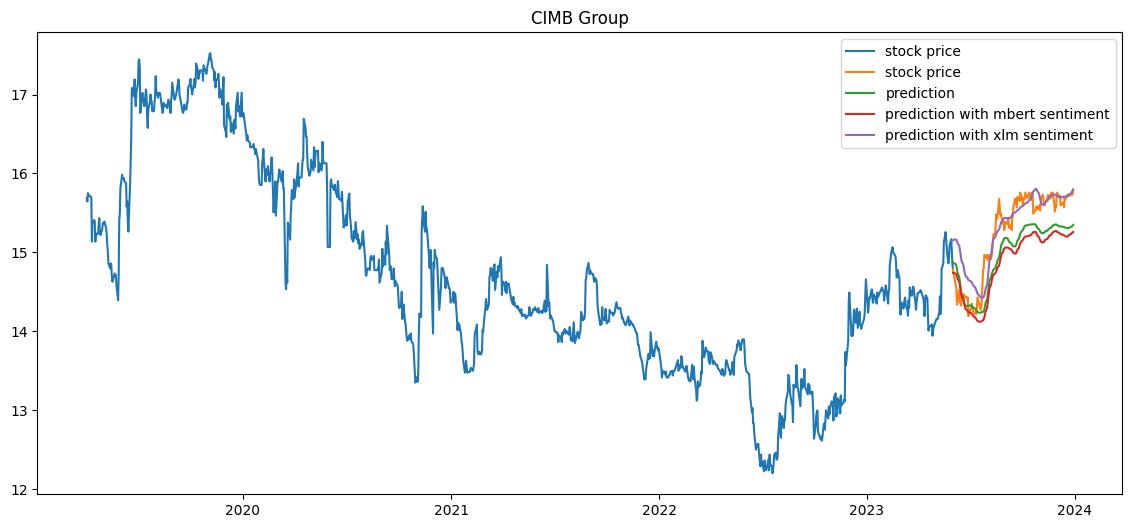

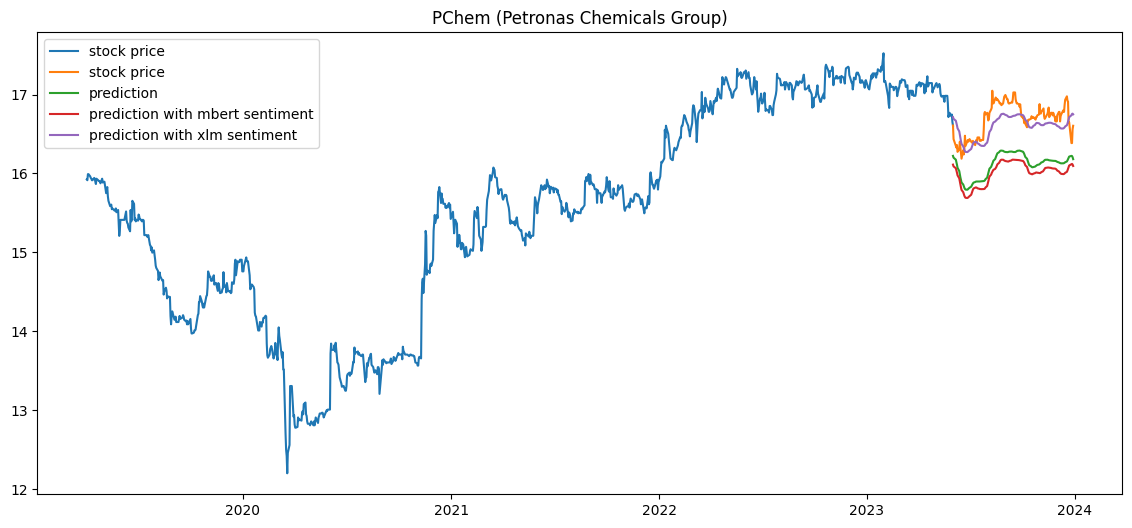

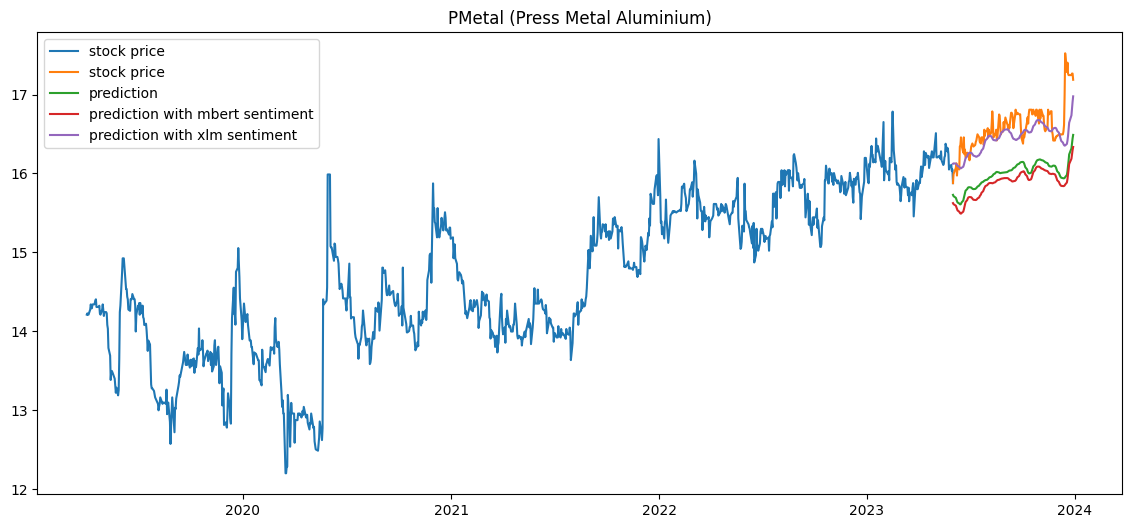

In [ ]:
for i in stockList:

    plt.figure(figsize=(14,6))
    plt.title(i)
    plt.plot(pred_result[i]["Date_train"],pred_result[i]["True_train"] )
    plt.plot(pred_result[i]["Date_test"],pred_result[i]["True_test"] )
    plt.plot(pred_result[i]["Date_test"],pred_result[i]["Pred"])
    plt.plot(pred_result[i]["Date_test"],pred_result[i]["mbert_Pred"])
    plt.plot(pred_result[i]["Date_test"],pred_result[i]["xlm_Pred"])


    plt.legend(['stock price', 'stock price', 'prediction','prediction with mbert sentiment','prediction with xlm sentiment'])